In [1]:
from utils.libraries import *
from utils.objects import *
from utils.functions import *
from definitions import *

## Collecting & Preparing the data

### Setting up the configuration

In [25]:
# Se utiliza un rango de 20 años para la extraccion de datos económicos
timeframe = 365*20
today = datetime.today()
end = today.strftime("%Y-%m-%d")
start = (today - dt.timedelta(days=timeframe)).strftime("%Y-%m-%d")
periods = "W"

medidas = ["mean", "median", "mode", "Min", "Percentil_25", "Percentil_75","Max", "var", "std", "skew", "kurt"]

ROOT_PATH = Path(ROOT_PATH)
config_paths = [
    "config\Market_Data_Config.csv",
    "config\Economic_Data_Config.csv",
    "config\Calc_Data_Config.csv"
]
market_config = ROOT_PATH.joinpath(config_paths[0])
economic_config = ROOT_PATH.joinpath(config_paths[1]).abspath()
calc_config = ROOT_PATH.joinpath(config_paths[2]).abspath()

target_list = pd.read_csv(market_config, sep=";", header=0).loc[:, "Codigo"].to_list()

markets_used = ['SPY', 'GDX', 'BND']

target = "SP500"

# ML random seed
seed = 2

extract = True

cutoff_date = "2023-01-01"

### Loading and extracting the data

In [26]:
# Initialize the Economic Data Analyzer class
eda = EconomicDataAnalyzer()

In [27]:
# Load the Market Data
print("> Load the market data config")
market = eda.read_config(market_config)
market_dict = eda.convert_to_dictionary(markets_used=markets_used)
market_dict = market_dict['Market']
# Load the economic data config
print("> Load the economic data config")
econ = eda.read_config(economic_config)
fred_series_dict = eda.convert_to_dictionary(markets_used=None)
fred_series_dict = fred_series_dict["Indicador"]
calc = eda.read_config(calc_config)
series_calc_dict = eda.convert_to_dictionary(markets_used=None)
series_calc_dict = series_calc_dict["Indicador"]
# Setting up the indicator dictionaries
print("> Setting up the indicator dictionaries")
indicators = {}
for ind in list(econ["Tipo"].unique()):
    indicators[ind] = econ[econ["Tipo"] == ind]["Indicador"].to_list()
if extract == True:
    # Extracting the indicator data
    print("> Extracting the indicator data")
    indicators_df = eda.indicator_extraction(fred_series_dict, series_calc_dict, root_path=ROOT_PATH)
    # Extracting the market data
    print("> Extracting the market data")
    stocks = list(market_dict.keys())
    market_df = eda.market_extraction(stocks, start, end, root_path=ROOT_PATH)
else:
    print("No data extraction, reading data from data file")
    path = ROOT_PATH.joinpath('data', 'raw', 'indicators_df.csv')
    indicators_df = pd.read_csv(path)
    path = ROOT_PATH.joinpath('data', 'raw', 'market_df.csv')
    market_df = pd.read_csv(path)

> Load the market data config
> Load the economic data config
> Setting up the indicator dictionaries
> Extracting the indicator data
   -->Extracting 10-Year Treasury Yield...
   -->Extracting 2-Year Treasury Yield...
   -->Extracting Federal Funds Effective Rate...
   -->Extracting 1-Month Treasury Yield...
   -->Extracting 3-Month Treasury Yield...
   -->Extracting 5-Year Treasury Yield...
   -->Extracting 20-Year Treasury Yield...
   -->Extracting 30-Year Treasury Yield...
   -->Extracting 15-Year Mortgage Rate...
   -->Extracting 30-Year Mortgage Rate...
   -->Extracting Unemployment Rate...
   -->Extracting GDP...
   -->Extracting Real GDP...
   -->Extracting CPI...
   -->Extracting PPI...
   -->Extracting Consumer Confidence Index...
   -->Extracting Government Debt...
   -->Extracting Debt Service vs Disposable Income...
   -->Extracting US Dollar Index...
   -->Extracting Corporate Profits...
   -->Extracting EBIT...
   -->Extracting Retained Earnings...
   -->Extracting Build

## Preparing the data

### Data cleaning

In [28]:
# Cleaning the indicator data
print("> Cleaning the indicator data")
df_indicators, df_indicators_cum, df_indicators_diff, df_indicators_rets, df_indicators_limpio = eda.limpiar_indicators(
    df_indicators=indicators_df, 
    indicator_dict=indicators, 
    resample=periods, 
    fill_method="ffill", 
    start=start, 
    end=end, 
    root_path=ROOT_PATH)
# Cleaning the market data
print("> Cleaning market data")
df_market, df_markets_rets, df_markets_cum, df_markets_diff  = eda.limpiar_markets(
    markets_dict=market_dict,
    df_markets=market_df,
    resample=periods, 
    fill_method="ffill", 
    start=start, 
    end=end, 
    root_path=ROOT_PATH)

> Cleaning the indicator data
> Cleaning market data


### Merge indicator and market data

In [29]:
list_market_dfs = [df_market,df_markets_rets,df_markets_cum,df_markets_diff]
list_indicators_dfs = [df_indicators_limpio,df_indicators_rets,df_indicators_cum,df_indicators_diff]

df_all_data, df_all_data_rets, df_all_data_cum, df_all_data_diff = eda.merge_data(list_market_dfs, list_indicators_dfs)

## Feature Engineering

### Remove Outliers 

In [30]:
df = eda.remove_outliers(df_all_data_rets)

### Adding features

In [31]:
df_all_data["CAPE Ratio"] = df_all_data["SP500"]/(df_all_data["Corporate Profits"]*0.01)
df["CAPE Ratio"] = df_all_data["SP500"]/(df_all_data["Corporate Profits"]*0.01)

# df_all_data["CAPE Ratio"].plot()
def trend_line(df, name, deg=2):
    coef = np.polyfit(range(0,len(df[name])), df[name], deg)
    x_trend = np.linspace(0,len(df[name]),len(df[name]))
    y_trend = np.polyval(coef, x_trend)
    df = pd.DataFrame(y_trend, index=df.index, columns=[name])
    return df

# df_all_data = pd.DataFrame()
df_all_data["SP_GDP"] = df_all_data["SP500"]/(df_all_data["GDP"]*.01)
df_all_data["SP_GDP_trend"] = trend_line(df_all_data, "SP_GDP", deg=5)
df["SP_GDP"] = df_all_data["SP500"]/(df_all_data["GDP"]*.01)
df["SP_GDP_trend"] = trend_line(df_all_data, "SP_GDP", deg=5)

# df_all_data = pd.DataFrame()
std = df_all_data["SP_GDP"].std()
df_all_data["SP_GDP_1std"] = df_all_data["SP_GDP_trend"] + (std)
df["SP_GDP_1std"] = df_all_data["SP_GDP_trend"] + (std)

# df_all_data = df_all_data.copy()
# df_ts = df_all_data.loc[:,df_all_data.columns.str.contains(f"t-")]
# df_all_data.drop(df_ts.columns,axis=1,inplace=True)
for ma in df_all_data.columns:
    df_all_data[f"{ma}_MA"] = df_all_data[[ma]].rolling(window=52).mean().fillna(method="ffill").fillna(method="bfill")
    df_all_data[f"{ma}_trend"] = trend_line(df_all_data[[ma]], ma, deg=6)
    df_all_data[f"{ma}_MA_trend_dif"] = df_all_data[f"{ma}_trend"] - df_all_data[f"{ma}_MA"]
    
    df[f"{ma}_MA"] = df_all_data[[ma]].rolling(window=52).mean().fillna(method="ffill").fillna(method="bfill")
    df[f"{ma}_trend"] = trend_line(df_all_data[[ma]], ma, deg=6)
    df[f"{ma}_MA_trend_dif"] = df_all_data[f"{ma}_trend"] - df_all_data[f"{ma}_MA"]

### Creating lags in the data

In [32]:
list_data_dfs = [df_all_data,df_all_data_rets,df_all_data_cum,df_all_data_diff]

df_all_lag_data, df_all_lag_data_rets, df_all_lag_data_cum, df_all_lag_data_diff = eda.lag_data(list_data_dfs, target, n_lags=12)

In [166]:
df = eda.remove_outliers(df_all_lag_data_rets)

## Data Preprocessing

In [167]:
econ_ml = Preprocessor()

### Feature Reduction

#### Feature selection by correlation

In [168]:
df_feat_corr = pd.DataFrame(df.corr().loc[target,:].sort_values(ascending=False))
df_feat_relevant_corr = df_feat_corr[(df_feat_corr[target]>0.05) | (df_feat_corr[target]<-0.05)]
df_feat_relevant_corr

,SP500
SP500,1.000000
1-Month Treasury Yield (t-10),0.079347
1-Month Treasury Yield (t-8),0.073924
Government Debt to GDP (t-11),0.073202
1-Month Treasury Yield (t-9),0.072544
...,...
PPI (t-10),-0.081338
Federal Funds Effective Rate (t-2),-0.084764
Federal Funds Effective Rate (t-1),-0.114186
Federal Funds Effective Rate,-0.120569


#### Indentifying the most important features

##### Splitting the data

##### Creating the baseline for feature importance

In [184]:
def baseline_ml(target, df, baseline_def=econ_ml.define_baseline_models()):
    X_train, X_test, y_train, y_test = econ_ml.train_test_split_data(data=df, target_col=target, test_size=0.15)
    baseline_models = baseline_def
    # For model scoring
    model_results = pd.DataFrame()
    model_scores_dict = {}
    model_mse_dict = {}
    model_r2_dict = {}

    # For model prediction data saving
    preds = {}
    preds[target] = pd.Series(y_test)

    for name, model in baseline_models.items():
        print("Processing "+name)
        if name == "PolynomialFeatures":
            pass
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # y_pred = pd.DataFrame(y_pred,index=y_test.index,columns=[name+"_"+target+"_pred"])
            y_pred = pd.Series(y_pred,index=y_test.index)
            preds[name+"_"+target+"_pred"] = y_pred
            score = model.score(X_train, y_train)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            model_scores_dict[name] = score
            model_mse_dict[name] = mse
            model_r2_dict[name] = r2

    model_results = model_results.append([model_scores_dict,model_mse_dict,model_r2_dict], ignore_index=True).T.sort_values(by=0, ascending=False)
    model_results.columns = ["score","mse","r2"]
    model_results["rmse"] = np.sqrt(model_results["mse"])
    baseline_preds = pd.DataFrame(preds)

    # Pick the models that have a score above 0.75
    model_results = model_results[model_results.loc[:,"score"]>(max(model_results.loc[:,"score"])*.75)]
    # Sort by rmse
    model_results.sort_values(by="rmse",ascending=True,inplace=True)
    # Pick the model with the best rmse
    best_model_name = model_results.index[0]
    best_model = baseline_models[best_model_name]
    print("--> We choose "+str(model_results.index.values)+" as the best models due to their high scores and rmse")
    return model_results, baseline_preds, best_model, best_model_name

In [170]:
model_results, baseline_preds, best_model, best_model_name = baseline_ml(target, df, baseline_def=econ_ml.define_baseline_models())

Processing RandomForest


Processing GradientBoosting
Processing SVR
Processing KNeighborsRegressor
Processing XGBRegressor


In [171]:
print("> Performing feature importance analysis")
df_top_data, feature_importance, top_feature_importance, score = econ_ml.feature_importance(target=target, 
                                                                                                  df_data=df.loc[:cutoff_date],
                                                                                                  model=best_model,
                                                                                                  accepted_importance=0.9)

> Performing feature importance analysis


#### Feature removal

In [172]:
def feature_removal(df, df_top_data, model_results, best_model_name, score):
    best_model_score = model_results.loc[best_model_name,"score"]
    if score > best_model_score*.8:
        print("We choose to remove "+str(len(df.columns)-len(df_top_data.columns))+" features")
        df = df_top_data.copy()
    else:
        print("We choose to keep the original df with "+str(len(df_top_data.columns))+" features")
    return df

In [173]:
df = feature_removal(df, df_top_data, model_results, best_model_name, score)

We choose to remove 241 features


## Performing Machine Learning

### Pick the best model

In [185]:
model_results, baseline_preds, best_model, best_model_name = baseline_ml(target, df, baseline_def=econ_ml.define_baseline_models())

Processing RandomForest
Processing GradientBoosting
Processing SVR
Processing KNeighborsRegressor
Processing XGBRegressor
--> We choose ['RandomForest' 'XGBRegressor'] as the best models due to their high scores and rmse


### Defining the Pipelines

In [188]:
# Defining the pipelines
for name, model in baseline_models.items():
    if name in (model_results.index.values):
        print("Processing "+name)
        pipe = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("selectkbest",SelectKBest()), 
            (name, model)
        ])


Processing RandomForest
Processing XGBRegressor


In [ ]:
model_results

In [ ]:
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# score = model.score(X_train, y_train)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# # print("score "+name+" "+str(round(score,5)))
# # print("mse "+name+" "+str(round(mse,5)))
# # print("r2 "+name+" "+str(round(r2,5)))
# model_scores_dict[name] = score
# model_mse_dict[name] = mse
# model_r2_dict[name] = r2

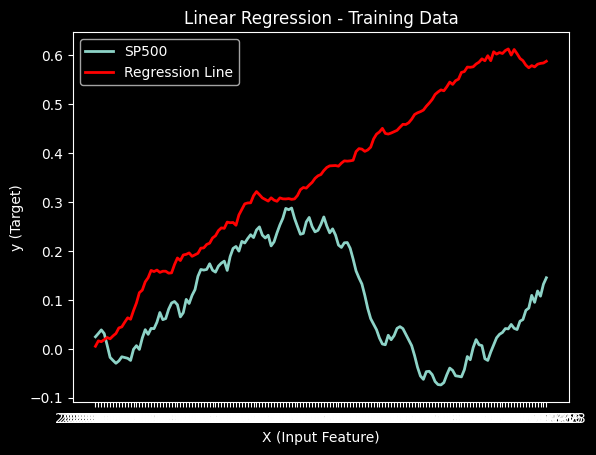

In [86]:
# plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.figure()
plt.plot(y_test.cumsum(), linewidth=2, label=target)
plt.plot(y_pred.cumsum(), color='red', linewidth=2, label='Regression Line')
plt.xlabel('X (Input Feature)')
plt.ylabel('y (Target)')
plt.title('Linear Regression - Training Data')
plt.legend()
plt.show()

In [ ]:
X_train_fi, X_test_fi, y_train_fi, y_test_fi = econ_ml.train_test_split_data(data=df_top_data, target_col=target, test_size=0.15)

In [ ]:
baseline_models = econ_ml.define_baseline_models()
model_results_fi = pd.DataFrame()
model_scores_dict = {}
model_mse_dict = {}
model_r2_dict = {}

for name, model in baseline_models.items():
    print("Processing "+name)
    if name == "PolynomialFeatures":
        pass
    else:
        model.fit(X_train_fi, y_train_fi)
        y_pred = model.predict(X_test_fi)
        score = model.score(X_train_fi, y_train_fi)
        mse = mean_squared_error(y_test_fi, y_pred)
        r2 = r2_score(y_test_fi, y_pred)
        print("score "+name+" "+str(round(score,5)))
        print("mse "+name+" "+str(round(mse,5)))
        print("r2 "+name+" "+str(round(r2,5)))
        model_scores_dict[name] = score
        model_mse_dict[name] = mse
        model_r2_dict[name] = r2
        

model_results_fi = model_results_fi.append([model_scores_dict,model_mse_dict,model_r2_dict], ignore_index=True).T.sort_values(by=0, ascending=False)
model_results_fi.columns = ["score","mse","r2"]
model_results_fi["rmse"] = np.sqrt(model_results_fi["mse"])

In [ ]:
model_results

In [ ]:
model_results_fi

### Scaling the data

In [ ]:
X_train_scale, X_test_scale = econ_ml.scaler(X_train=X_train, X_test=X_test)

## Performing Machine Learning

In [ ]:
def lstm_model(epochs,batch_size,validation_split):
    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
    lstm_model.add(LSTM(32))
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return lstm_model

def gru_model(epochs,batch_size,validation_split):
    # gru model
    gru_model = Sequential()
    gru_model.add(GRU(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
    gru_model.add(GRU(32))
    gru_model.add(Dense(units=1))
    gru_model.compile(optimizer='adam', loss='mse')
    gru_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return gru_model

def cnn_model(epochs,batch_size,validation_split):
    # cnn model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=1))
    cnn_model.compile(optimizer='adam', loss='mse')
    cnn_model.fit(X_train_scale, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return cnn_model


In [ ]:
models = {
    "LSTM":lstm_model(epochs=15,batch_size=16,validation_split=0.2),
    "GRU":gru_model(epochs=15,batch_size=16,validation_split=0.2),
    "CNN":cnn_model(epochs=15,batch_size=16,validation_split=0.2)
}

In [ ]:
model_eval = {}
for name, model in models.items():
    loss_score = model.evaluate(X_test, y_test)
    print(f"Evaluate the model: {name}: {loss_score}")
    model_eval[name] = loss_score
    # model.evaluate(X_test, y_test)
model_eval_df = pd.DataFrame(model_eval.values(), index=model_eval.keys()).sort_values(by=0, ascending=True)
for name, model in models.items():
    print(f"Review of model: {name}")
    # if name != "CNN":
    try:
        df_history = pd.DataFrame({"Loss":model.history.history['loss'], "Val_Loss":model.history.history['val_loss']})
        df_history.plot(figsize=(10, 6), title=name)
    except:
        pass
    pred = model.predict(X_test)
    predictions = pd.DataFrame(pred, index=y_test.index)
    predictions.index = pd.to_datetime(predictions.index)
    predictions.columns = [target+"_Pred"]

    model.save(f'models\models\{name}_best_model.h5')
    model.save_weights(f'models\weights\{name}_best_model.h5') 

    y_test.index = pd.to_datetime(y_test.index)
    EMF_forecast = pd.concat([y_test, predictions], axis=1).cumsum()
    # print(model.summary())
    plt.figure(figsize=(10, 6))
    plt.title(f"{name} -> {X_test.index[0]} - {X_test.index[-1]}")
    plt.plot(EMF_forecast, label=EMF_forecast.columns)
    plt.legend()

In [ ]:
model_eval_df.columns = ["mse"]
model_eval_df["rmse"] = np.sqrt(model_eval_df["mse"])

In [ ]:
all_model_results = pd.concat([model_eval_df,model_results], axis=0).sort_values(by='rmse', ascending=True)
best_model = all_model_results.iloc[0]
if name == best_model.name:
    EMF_forecast.to_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\EMF_project"+f"\EMF_forecast_{target}.csv")